In [8]:
DEBUG_FLAG = False

In [16]:
import os
import math
import argparse
import gc
import numpy as np
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict

import torch
from torch.autograd import Variable

In [17]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir, dataset_name):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    last_num = None
    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                # select the most hazed images in SOTS-indoor
                if dataset_name=='SOTS-indoor' and '_' in fname and '_10' not in fname:
                    continue
                # skip images saved in temp folder
                if '.ipynb_checkpoints' in root:
                    continue
                # dedup for SOTS-outdoor
                if dataset_name=='SOTS-outdoor':
                    num = fname.split('_')[0]
                    if num == last_num:
                        continue
                    last_num = num
                path = os.path.join(root, fname)
                images.append(path)
    return images

In [18]:
## Dataset loader

def resize_img(img):
    im_w, im_h = img.size
    # resize the big image to save the gpu memory
    size_limit = 1024
    while im_w > size_limit or im_h > size_limit:
        img = img.resize((int(im_w // 2), int(im_h // 2)))  
        im_w, im_h = img.size
    # resize the image into multiple of 4
    if im_w % 4 != 0 or im_h % 4 != 0:
        img = img.resize((int(im_w // 4 * 4), int(im_h // 4 * 4))) 
        im_w, im_h = img.size
    return img

result_cache = {}
def dataset_loader(name):
    """
    Load the dataset into the memory
    name: 'I-HAZY', 'O-HAZY', 'SOTS-indoor', 'SOTS-outdoor'
    """
    if name in result_cache:
        return result_cache[name]
    else:
        hazy_path = {
            'I-HAZY' : '# I-HAZY NTIRE 2018/hazy',
            'O-HAZY' : '# O-HAZY NTIRE 2018/hazy',
            'SOTS-indoor' : 'SOTS/indoor/hazy',
            'SOTS-outdoor' : 'SOTS/outdoor/hazy',
        }
        clear_path = {
            'I-HAZY' : '# I-HAZY NTIRE 2018/GT',
            'O-HAZY' : '# O-HAZY NTIRE 2018/GT',
            'SOTS-indoor' : 'SOTS/indoor/clear',
            'SOTS-outdoor' : 'SOTS/outdoor/clear',        
        }
        train_img_paths = make_dataset('dataset/'+hazy_path[name], name)
        truth_img_paths = make_dataset('dataset/'+clear_path[name], name)
        result = []
        for train_path, truth_path in zip(train_img_paths, truth_img_paths):
            train_img = resize_img(Image.open(train_path).convert('RGB'))
            truth_img = resize_img(Image.open(truth_path).convert('RGB'))
            result.append((train_img, truth_img))
        result_cache[name] = result
        return result

In [19]:
def psnr(target, ref):
    # convert image into float64
    target_data = np.array(target, dtype=np.float64)
    ref_data = np.array(ref,dtype=np.float64)
    # calculate difference
    diff = ref_data - target_data
    # flatten the rgb channels
    diff = diff.flatten('C')
    # calculate RSE
    rmse = math.sqrt(np.mean(diff ** 2.))
    # precision
    eps = np.finfo(np.float64).eps
    if(rmse == 0):
        rmse = eps 
    return 20*math.log10(255.0/rmse)

import pytorch_ssim
def ssim(img1,img2):
    img1 = torch.from_numpy(np.rollaxis(np.array(img1), 2)).float().unsqueeze(0)/255.0
    img2 = torch.from_numpy(np.rollaxis(np.array(img2), 2)).float().unsqueeze(0)/255.0   
    img1 = Variable(img1, requires_grad=False)    # torch.Size([256, 256, 3])
    img2 = Variable(img2, requires_grad=False)
    ssim_value = pytorch_ssim.ssim(img1, img2).item()
    return ssim_value

In [20]:
## debug dataset paths
if DEBUG_FLAG:
    hazy_path = {
        'I-HAZY' : '# I-HAZY NTIRE 2018/hazy',
        'O-HAZY' : '# O-HAZY NTIRE 2018/hazy',
        'SOTS-indoor' : 'SOTS/indoor/hazy',
        'SOTS-outdoor' : 'SOTS/outdoor/hazy',
    }
    clear_path = {
        'I-HAZY' : '# I-HAZY NTIRE 2018/GT',
        'O-HAZY' : '# O-HAZY NTIRE 2018/GT',
        'SOTS-indoor' : 'SOTS/indoor/clear',
        'SOTS-outdoor' : 'SOTS/outdoor/clear',        
    }
    for path1, path2 in zip(make_dataset('dataset/'+hazy_path[dataset_name], dataset_name), make_dataset('dataset/'+clear_path[dataset_name], dataset_name)):
        print(path1 + '        ' + path2)

In [34]:
### Matlab results

datasets = ['I-HAZY', 'O-HAZY', 'SOTS-indoor', 'SOTS-outdoor']
levels = [2,3,4]
wnames = ["haar","db10","db45","coif1","coif2","sym2","sym4","fk4","dmey","bior1.1","rbio1.1"]

OPC_psnr = defaultdict(list)
OPC_ssim = defaultdict(list)

count = 0

with tqdm(total=len(datasets)*len(levels)*len(wnames)) as pbar:
    for dataset in datasets:
        for level in levels:
            for wname in wnames:
                def OCA_benchmark(datset):
                    hazy_path = {
                        'I-HAZY' : '# I-HAZY NTIRE 2018/hazy',
                        'O-HAZY' : '# O-HAZY NTIRE 2018/hazy',
                        'SOTS-indoor' : 'SOTS/indoor/hazy',
                        'SOTS-outdoor' : 'SOTS/outdoor/hazy',
                    }
                    clear_path = {
                        'I-HAZY' : '# I-HAZY NTIRE 2018/GT',
                        'O-HAZY' : '# O-HAZY NTIRE 2018/GT',
                        'SOTS-indoor' : 'SOTS/indoor/clear',
                        'SOTS-outdoor' : 'SOTS/outdoor/clear',        
                    }
                    OPC_psnr = []
                    OPC_ssim = []
                    train_img_paths = make_dataset('dataset/'+hazy_path[dataset], dataset)
                    result_img_paths = make_dataset(f'opc_output/{level}/{wname}/{hazy_path[dataset]}', dataset)
                    truth_img_paths = make_dataset('dataset/'+clear_path[dataset], dataset)
                    for train_path, result_path, truth_path in list(zip(train_img_paths, result_img_paths, truth_img_paths)):
                        train_img = resize_img(Image.open(train_path).convert('RGB'))
                        result_img = resize_img(Image.open(result_path).convert('RGB'))
                        truth_img = resize_img(Image.open(truth_path).convert('RGB'))
                        psnr_value = psnr(result_img, truth_img)
                        ssim_value = ssim(result_img, truth_img)
                        OPC_psnr.append(psnr_value)
                        OPC_ssim.append(ssim_value)
                    return OPC_psnr, OPC_ssim

                index=(dataset, level, wname)
                OPC_psnr[index], OPC_ssim[index] = OCA_benchmark(dataset)
                count += 1
                pbar.update()
                print(f'({count}/{len(datasets)*len(levels)*len(wnames)}){index}  average psnr: {np.mean(OPC_psnr[index])}   average ssim: {np.mean(OPC_ssim[index])}')
                gc.collect()
                torch.cuda.empty_cache()

  1%|▌                                                                               | 1/132 [00:30<1:06:06, 30.27s/it]

(1/132)('I-HAZY', 2, 'haar')  average psnr: 12.735614836562402   average ssim: 0.6289330234130224


  2%|█▏                                                                              | 2/132 [01:00<1:05:38, 30.30s/it]

(2/132)('I-HAZY', 2, 'db10')  average psnr: 12.783691363211059   average ssim: 0.6327668885389964


  2%|█▊                                                                              | 3/132 [01:30<1:05:08, 30.30s/it]

(3/132)('I-HAZY', 2, 'db45')  average psnr: 12.838168068272127   average ssim: 0.6352906872828802


  3%|██▍                                                                             | 4/132 [02:01<1:04:37, 30.30s/it]

(4/132)('I-HAZY', 2, 'coif1')  average psnr: 12.754964402050149   average ssim: 0.6309849411249161


  4%|███                                                                             | 5/132 [02:31<1:04:12, 30.34s/it]

(5/132)('I-HAZY', 2, 'coif2')  average psnr: 12.76421219241002   average ssim: 0.6318301777044932


  5%|███▋                                                                            | 6/132 [03:02<1:03:48, 30.38s/it]

(6/132)('I-HAZY', 2, 'sym2')  average psnr: 12.762160078080164   average ssim: 0.6312564214070638


  5%|████▏                                                                           | 7/132 [03:32<1:03:17, 30.38s/it]

(7/132)('I-HAZY', 2, 'sym4')  average psnr: 12.760332864548726   average ssim: 0.6316077182690303


  6%|████▊                                                                           | 8/132 [04:02<1:02:47, 30.38s/it]

(8/132)('I-HAZY', 2, 'fk4')  average psnr: 12.752867380945037   average ssim: 0.630277344584465


  7%|█████▍                                                                          | 9/132 [04:33<1:02:16, 30.38s/it]

(9/132)('I-HAZY', 2, 'dmey')  average psnr: 12.789721867787014   average ssim: 0.6329384843508402


  8%|█████▉                                                                         | 10/132 [05:03<1:01:42, 30.35s/it]

(10/132)('I-HAZY', 2, 'bior1.1')  average psnr: 12.735614836562402   average ssim: 0.6289330234130224


  8%|██████▌                                                                        | 11/132 [05:33<1:01:10, 30.33s/it]

(11/132)('I-HAZY', 2, 'rbio1.1')  average psnr: 12.735614836562402   average ssim: 0.6289330234130224


  9%|███████▏                                                                       | 12/132 [06:04<1:00:38, 30.32s/it]

(12/132)('I-HAZY', 3, 'haar')  average psnr: 13.191127487718967   average ssim: 0.6458364794651668


 10%|███████▊                                                                       | 13/132 [06:34<1:00:01, 30.27s/it]

(13/132)('I-HAZY', 3, 'db10')  average psnr: 13.237781416209113   average ssim: 0.6526461611191432


 11%|████████▌                                                                        | 14/132 [07:04<59:32, 30.27s/it]

(14/132)('I-HAZY', 3, 'db45')  average psnr: 13.32571842670804   average ssim: 0.6578607976436615


 11%|█████████▏                                                                       | 15/132 [07:34<59:03, 30.29s/it]

(15/132)('I-HAZY', 3, 'coif1')  average psnr: 13.1720367514938   average ssim: 0.6485776374737422


 12%|█████████▊                                                                       | 16/132 [08:05<58:37, 30.32s/it]

(16/132)('I-HAZY', 3, 'coif2')  average psnr: 13.211592063666801   average ssim: 0.6502358843882878


 13%|██████████▍                                                                      | 17/132 [08:35<58:09, 30.34s/it]

(17/132)('I-HAZY', 3, 'sym2')  average psnr: 13.205718055085871   average ssim: 0.6487867683172226


 14%|███████████                                                                      | 18/132 [09:05<57:30, 30.27s/it]

(18/132)('I-HAZY', 3, 'sym4')  average psnr: 13.220655997999435   average ssim: 0.6503597567478816


 14%|███████████▋                                                                     | 19/132 [09:35<56:56, 30.23s/it]

(19/132)('I-HAZY', 3, 'fk4')  average psnr: 13.18750697237801   average ssim: 0.6470041245222091


 15%|████████████▎                                                                    | 20/132 [10:06<56:25, 30.23s/it]

(20/132)('I-HAZY', 3, 'dmey')  average psnr: 13.258517159590868   average ssim: 0.6525170087814331


 16%|████████████▉                                                                    | 21/132 [10:36<56:00, 30.27s/it]

(21/132)('I-HAZY', 3, 'bior1.1')  average psnr: 13.191127487718967   average ssim: 0.6458364794651668


 17%|█████████████▌                                                                   | 22/132 [11:06<55:29, 30.27s/it]

(22/132)('I-HAZY', 3, 'rbio1.1')  average psnr: 13.191127487718967   average ssim: 0.6458364794651668


 17%|██████████████                                                                   | 23/132 [11:37<54:58, 30.26s/it]

(23/132)('I-HAZY', 4, 'haar')  average psnr: 13.673518252057487   average ssim: 0.6613353351751964


 18%|██████████████▋                                                                  | 24/132 [12:07<54:26, 30.25s/it]

(24/132)('I-HAZY', 4, 'db10')  average psnr: 13.672612574060077   average ssim: 0.6680072029431661


 19%|███████████████▎                                                                 | 25/132 [12:37<53:56, 30.25s/it]

(25/132)('I-HAZY', 4, 'db45')  average psnr: 13.718466458170779   average ssim: 0.6728554487228393


 20%|███████████████▉                                                                 | 26/132 [13:07<53:27, 30.26s/it]

(26/132)('I-HAZY', 4, 'coif1')  average psnr: 13.680723427183382   average ssim: 0.665214463075002


 20%|████████████████▌                                                                | 27/132 [13:38<52:59, 30.29s/it]

(27/132)('I-HAZY', 4, 'coif2')  average psnr: 13.604161964971114   average ssim: 0.665057568748792


 21%|█████████████████▏                                                               | 28/132 [14:08<52:33, 30.32s/it]

(28/132)('I-HAZY', 4, 'sym2')  average psnr: 13.703613646054658   average ssim: 0.6661512235800425


 22%|█████████████████▊                                                               | 29/132 [14:38<52:03, 30.32s/it]

(29/132)('I-HAZY', 4, 'sym4')  average psnr: 13.642309548472532   average ssim: 0.667592030763626


 23%|██████████████████▍                                                              | 30/132 [15:09<51:30, 30.30s/it]

(30/132)('I-HAZY', 4, 'fk4')  average psnr: 13.661227508923428   average ssim: 0.6623783111572266


 23%|███████████████████                                                              | 31/132 [15:39<51:05, 30.35s/it]

(31/132)('I-HAZY', 4, 'dmey')  average psnr: 13.715431841758734   average ssim: 0.6676159203052521


 24%|███████████████████▋                                                             | 32/132 [16:09<50:34, 30.34s/it]

(32/132)('I-HAZY', 4, 'bior1.1')  average psnr: 13.673518252057487   average ssim: 0.6613353351751964


 25%|████████████████████▎                                                            | 33/132 [16:40<50:05, 30.36s/it]

(33/132)('I-HAZY', 4, 'rbio1.1')  average psnr: 13.673518252057487   average ssim: 0.6613353351751964


 26%|████████████████████▎                                                          | 34/132 [17:39<1:03:53, 39.12s/it]

(34/132)('O-HAZY', 2, 'haar')  average psnr: 15.293552669731147   average ssim: 0.720130737622579


 27%|████████████████████▉                                                          | 35/132 [18:38<1:12:53, 45.08s/it]

(35/132)('O-HAZY', 2, 'db10')  average psnr: 15.447172982770372   average ssim: 0.7293963207138909


 27%|█████████████████████▌                                                         | 36/132 [19:38<1:19:03, 49.41s/it]

(36/132)('O-HAZY', 2, 'db45')  average psnr: 15.40063220343861   average ssim: 0.7296002176072862


 28%|██████████████████████▏                                                        | 37/132 [20:37<1:22:59, 52.42s/it]

(37/132)('O-HAZY', 2, 'coif1')  average psnr: 15.36688082184482   average ssim: 0.7251223378711277


 29%|██████████████████████▋                                                        | 38/132 [21:37<1:25:33, 54.61s/it]

(38/132)('O-HAZY', 2, 'coif2')  average psnr: 15.403118974472575   average ssim: 0.7268102036582099


 30%|███████████████████████▎                                                       | 39/132 [22:37<1:26:59, 56.12s/it]

(39/132)('O-HAZY', 2, 'sym2')  average psnr: 15.376217597928195   average ssim: 0.7251908196343316


 30%|███████████████████████▉                                                       | 40/132 [23:36<1:27:43, 57.21s/it]

(40/132)('O-HAZY', 2, 'sym4')  average psnr: 15.39470480622071   average ssim: 0.7265547487470839


 31%|████████████████████████▌                                                      | 41/132 [24:36<1:27:53, 57.95s/it]

(41/132)('O-HAZY', 2, 'fk4')  average psnr: 15.328192312222356   average ssim: 0.7224646806716919


 32%|█████████████████████████▏                                                     | 42/132 [25:35<1:27:33, 58.37s/it]

(42/132)('O-HAZY', 2, 'dmey')  average psnr: 15.430668658290578   average ssim: 0.7283360441525777


 33%|█████████████████████████▋                                                     | 43/132 [26:35<1:27:17, 58.85s/it]

(43/132)('O-HAZY', 2, 'bior1.1')  average psnr: 15.293552669731147   average ssim: 0.720130737622579


 33%|██████████████████████████▎                                                    | 44/132 [27:35<1:26:36, 59.05s/it]

(44/132)('O-HAZY', 2, 'rbio1.1')  average psnr: 15.293552669731147   average ssim: 0.720130737622579


 34%|██████████████████████████▉                                                    | 45/132 [28:34<1:25:49, 59.19s/it]

(45/132)('O-HAZY', 3, 'haar')  average psnr: 15.517538141625957   average ssim: 0.7249162356058757


 35%|███████████████████████████▌                                                   | 46/132 [29:34<1:25:07, 59.38s/it]

(46/132)('O-HAZY', 3, 'db10')  average psnr: 15.617047544687814   average ssim: 0.7343323932753669


 36%|████████████████████████████▏                                                  | 47/132 [30:34<1:24:17, 59.50s/it]

(47/132)('O-HAZY', 3, 'db45')  average psnr: 15.529874037075832   average ssim: 0.7317860735787286


 36%|████████████████████████████▋                                                  | 48/132 [31:34<1:23:26, 59.60s/it]

(48/132)('O-HAZY', 3, 'coif1')  average psnr: 15.621474932055152   average ssim: 0.7313117702802022


 37%|█████████████████████████████▎                                                 | 49/132 [32:34<1:22:34, 59.70s/it]

(49/132)('O-HAZY', 3, 'coif2')  average psnr: 15.63950070781343   average ssim: 0.732502720091078


 38%|█████████████████████████████▉                                                 | 50/132 [33:34<1:21:43, 59.80s/it]

(50/132)('O-HAZY', 3, 'sym2')  average psnr: 15.603927436124488   average ssim: 0.7312747637430826


 39%|██████████████████████████████▌                                                | 51/132 [34:34<1:20:46, 59.84s/it]

(51/132)('O-HAZY', 3, 'sym4')  average psnr: 15.657136454232008   average ssim: 0.7333580944273207


 39%|███████████████████████████████                                                | 52/132 [35:33<1:19:39, 59.75s/it]

(52/132)('O-HAZY', 3, 'fk4')  average psnr: 15.538550400686477   average ssim: 0.7274250149726867


 40%|███████████████████████████████▋                                               | 53/132 [36:33<1:18:38, 59.72s/it]

(53/132)('O-HAZY', 3, 'dmey')  average psnr: 15.623035439673782   average ssim: 0.7332705961333381


 41%|████████████████████████████████▎                                              | 54/132 [37:33<1:17:38, 59.73s/it]

(54/132)('O-HAZY', 3, 'bior1.1')  average psnr: 15.517538141625957   average ssim: 0.7249162356058757


 42%|████████████████████████████████▉                                              | 55/132 [38:33<1:16:42, 59.78s/it]

(55/132)('O-HAZY', 3, 'rbio1.1')  average psnr: 15.517538141625957   average ssim: 0.7249162356058757


 42%|█████████████████████████████████▌                                             | 56/132 [39:33<1:15:48, 59.85s/it]

(56/132)('O-HAZY', 4, 'haar')  average psnr: 15.467388428231798   average ssim: 0.7190847675005595


 43%|██████████████████████████████████                                             | 57/132 [40:32<1:14:45, 59.81s/it]

(57/132)('O-HAZY', 4, 'db10')  average psnr: 15.585105355922737   average ssim: 0.7252776119444105


 44%|██████████████████████████████████▋                                            | 58/132 [41:32<1:13:44, 59.79s/it]

(58/132)('O-HAZY', 4, 'db45')  average psnr: 15.507769248675675   average ssim: 0.7158629258473714


 45%|███████████████████████████████████▎                                           | 59/132 [42:32<1:12:39, 59.73s/it]

(59/132)('O-HAZY', 4, 'coif1')  average psnr: 15.554090245619387   average ssim: 0.7251570251252916


 45%|███████████████████████████████████▉                                           | 60/132 [43:32<1:11:52, 59.89s/it]

(60/132)('O-HAZY', 4, 'coif2')  average psnr: 15.584484820581052   average ssim: 0.7253423876232571


 46%|████████████████████████████████████▌                                          | 61/132 [44:32<1:10:49, 59.85s/it]

(61/132)('O-HAZY', 4, 'sym2')  average psnr: 15.594706683431719   average ssim: 0.725747537612915


 47%|█████████████████████████████████████                                          | 62/132 [45:32<1:09:50, 59.86s/it]

(62/132)('O-HAZY', 4, 'sym4')  average psnr: 15.644324617674988   average ssim: 0.7281926234563192


 48%|█████████████████████████████████████▋                                         | 63/132 [46:31<1:08:43, 59.76s/it]

(63/132)('O-HAZY', 4, 'fk4')  average psnr: 15.496871043320205   average ssim: 0.7213128897878859


 48%|██████████████████████████████████████▎                                        | 64/132 [47:31<1:07:43, 59.76s/it]

(64/132)('O-HAZY', 4, 'dmey')  average psnr: 15.562318269535544   average ssim: 0.7234071612358093


 49%|██████████████████████████████████████▉                                        | 65/132 [48:31<1:06:42, 59.73s/it]

(65/132)('O-HAZY', 4, 'bior1.1')  average psnr: 15.467388428231798   average ssim: 0.7190847675005595


 50%|███████████████████████████████████████▌                                       | 66/132 [49:30<1:05:31, 59.56s/it]

(66/132)('O-HAZY', 4, 'rbio1.1')  average psnr: 15.467388428231798   average ssim: 0.7190847675005595


 51%|█████████████████████████████████████████                                        | 67/132 [49:50<51:36, 47.64s/it]

(67/132)('SOTS-indoor', 2, 'haar')  average psnr: 19.801847296878712   average ssim: 0.844877177476883


 52%|█████████████████████████████████████████▋                                       | 68/132 [50:09<41:54, 39.30s/it]

(68/132)('SOTS-indoor', 2, 'db10')  average psnr: 19.732770334403064   average ssim: 0.8396348416805267


 52%|██████████████████████████████████████████▎                                      | 69/132 [50:29<35:04, 33.40s/it]

(69/132)('SOTS-indoor', 2, 'db45')  average psnr: 19.16692567684739   average ssim: 0.8024255692958832


 53%|██████████████████████████████████████████▉                                      | 70/132 [50:49<30:16, 29.30s/it]

(70/132)('SOTS-indoor', 2, 'coif1')  average psnr: 19.940418716808068   average ssim: 0.8505644655227661


 54%|███████████████████████████████████████████▌                                     | 71/132 [51:09<26:52, 26.44s/it]

(71/132)('SOTS-indoor', 2, 'coif2')  average psnr: 19.972341825370492   average ssim: 0.8507341587543488


 55%|████████████████████████████████████████████▏                                    | 72/132 [51:28<24:23, 24.39s/it]

(72/132)('SOTS-indoor', 2, 'sym2')  average psnr: 19.933054846458027   average ssim: 0.8502208423614502


 55%|████████████████████████████████████████████▊                                    | 73/132 [51:48<22:37, 23.01s/it]

(73/132)('SOTS-indoor', 2, 'sym4')  average psnr: 19.989740941877596   average ssim: 0.852277501821518


 56%|█████████████████████████████████████████████▍                                   | 74/132 [52:08<21:19, 22.06s/it]

(74/132)('SOTS-indoor', 2, 'fk4')  average psnr: 19.86984644270822   average ssim: 0.8474218928813935


 57%|██████████████████████████████████████████████                                   | 75/132 [52:28<20:24, 21.49s/it]

(75/132)('SOTS-indoor', 2, 'dmey')  average psnr: 19.934282784500155   average ssim: 0.846979079246521


 58%|██████████████████████████████████████████████▋                                  | 76/132 [52:48<19:33, 20.96s/it]

(76/132)('SOTS-indoor', 2, 'bior1.1')  average psnr: 19.801847296878712   average ssim: 0.844877177476883


 58%|███████████████████████████████████████████████▎                                 | 77/132 [53:07<18:53, 20.60s/it]

(77/132)('SOTS-indoor', 2, 'rbio1.1')  average psnr: 19.801847296878712   average ssim: 0.844877177476883


 59%|███████████████████████████████████████████████▊                                 | 78/132 [53:27<18:15, 20.28s/it]

(78/132)('SOTS-indoor', 3, 'haar')  average psnr: 19.31251085902444   average ssim: 0.8321693909168243


 60%|████████████████████████████████████████████████▍                                | 79/132 [53:47<17:44, 20.09s/it]

(79/132)('SOTS-indoor', 3, 'db10')  average psnr: 18.978702647258814   average ssim: 0.818648852109909


 61%|█████████████████████████████████████████████████                                | 80/132 [54:06<17:18, 19.98s/it]

(80/132)('SOTS-indoor', 3, 'db45')  average psnr: 18.162042414797078   average ssim: 0.7602314102649689


 61%|█████████████████████████████████████████████████▋                               | 81/132 [54:26<16:52, 19.86s/it]

(81/132)('SOTS-indoor', 3, 'coif1')  average psnr: 19.516841962973057   average ssim: 0.8395433938503265


 62%|██████████████████████████████████████████████████▎                              | 82/132 [54:46<16:31, 19.83s/it]

(82/132)('SOTS-indoor', 3, 'coif2')  average psnr: 19.49678405417828   average ssim: 0.8373736441135406


 63%|██████████████████████████████████████████████████▉                              | 83/132 [55:05<16:10, 19.80s/it]

(83/132)('SOTS-indoor', 3, 'sym2')  average psnr: 19.364941221912932   average ssim: 0.838049373626709


 64%|███████████████████████████████████████████████████▌                             | 84/132 [55:25<15:50, 19.80s/it]

(84/132)('SOTS-indoor', 3, 'sym4')  average psnr: 19.488191261802502   average ssim: 0.8417530930042267


 64%|████████████████████████████████████████████████████▏                            | 85/132 [55:45<15:28, 19.75s/it]

(85/132)('SOTS-indoor', 3, 'fk4')  average psnr: 19.171779325527528   average ssim: 0.8310737454891205


 65%|████████████████████████████████████████████████████▊                            | 86/132 [56:05<15:18, 19.96s/it]

(86/132)('SOTS-indoor', 3, 'dmey')  average psnr: 19.345197585143254   average ssim: 0.8333716201782226


 66%|█████████████████████████████████████████████████████▍                           | 87/132 [56:25<14:54, 19.87s/it]

(87/132)('SOTS-indoor', 3, 'bior1.1')  average psnr: 19.31251085902444   average ssim: 0.8321693909168243


 67%|██████████████████████████████████████████████████████                           | 88/132 [56:45<14:33, 19.84s/it]

(88/132)('SOTS-indoor', 3, 'rbio1.1')  average psnr: 19.31251085902444   average ssim: 0.8321693909168243


 67%|██████████████████████████████████████████████████████▌                          | 89/132 [57:04<14:12, 19.82s/it]

(89/132)('SOTS-indoor', 4, 'haar')  average psnr: 16.95449404658296   average ssim: 0.7944700109958649


 68%|███████████████████████████████████████████████████████▏                         | 90/132 [57:24<13:50, 19.78s/it]

(90/132)('SOTS-indoor', 4, 'db10')  average psnr: 17.285750434641955   average ssim: 0.7731462144851684


 69%|███████████████████████████████████████████████████████▊                         | 91/132 [57:44<13:33, 19.85s/it]

(91/132)('SOTS-indoor', 4, 'db45')  average psnr: 16.1008639412084   average ssim: 0.7099860614538193


 70%|████████████████████████████████████████████████████████▍                        | 92/132 [58:04<13:16, 19.90s/it]

(92/132)('SOTS-indoor', 4, 'coif1')  average psnr: 17.592081221785186   average ssim: 0.8070721244812011


 70%|█████████████████████████████████████████████████████████                        | 93/132 [58:24<12:56, 19.91s/it]

(93/132)('SOTS-indoor', 4, 'coif2')  average psnr: 18.15429388750594   average ssim: 0.8078097176551818


 71%|█████████████████████████████████████████████████████████▋                       | 94/132 [58:44<12:35, 19.87s/it]

(94/132)('SOTS-indoor', 4, 'sym2')  average psnr: 17.455596360331494   average ssim: 0.806754800081253


 72%|██████████████████████████████████████████████████████████▎                      | 95/132 [59:03<12:12, 19.79s/it]

(95/132)('SOTS-indoor', 4, 'sym4')  average psnr: 17.77189706831603   average ssim: 0.8145030784606934


 73%|██████████████████████████████████████████████████████████▉                      | 96/132 [59:23<11:52, 19.79s/it]

(96/132)('SOTS-indoor', 4, 'fk4')  average psnr: 16.962556184589918   average ssim: 0.7931641781330109


 73%|███████████████████████████████████████████████████████████▌                     | 97/132 [59:43<11:33, 19.82s/it]

(97/132)('SOTS-indoor', 4, 'dmey')  average psnr: 17.348601640479984   average ssim: 0.787589921951294


 74%|██████████████████████████████████████████████████████████▋                    | 98/132 [1:00:03<11:14, 19.83s/it]

(98/132)('SOTS-indoor', 4, 'bior1.1')  average psnr: 16.95449404658296   average ssim: 0.7944700109958649


 75%|███████████████████████████████████████████████████████████▎                   | 99/132 [1:00:23<10:52, 19.77s/it]

(99/132)('SOTS-indoor', 4, 'rbio1.1')  average psnr: 16.95449404658296   average ssim: 0.7944700109958649


 76%|███████████████████████████████████████████████████████████                   | 100/132 [1:03:21<35:50, 67.21s/it]

(100/132)('SOTS-outdoor', 2, 'haar')  average psnr: 16.78500622316352   average ssim: 0.7935802036426901


 77%|██████████████████████████████████████████████████████████▉                  | 101/132 [1:06:18<51:50, 100.35s/it]

(101/132)('SOTS-outdoor', 2, 'db10')  average psnr: 16.938797922271394   average ssim: 0.7998354037602743


 77%|█████████████████████████████████████████████████████████▉                 | 102/132 [1:09:14<1:01:31, 123.05s/it]

(102/132)('SOTS-outdoor', 2, 'db45')  average psnr: 16.60340230322975   average ssim: 0.7474536744317388


 78%|██████████████████████████████████████████████████████████▌                | 103/132 [1:12:11<1:07:16, 139.18s/it]

(103/132)('SOTS-outdoor', 2, 'coif1')  average psnr: 16.83915547774917   average ssim: 0.8007336951852814


 79%|███████████████████████████████████████████████████████████                | 104/132 [1:15:09<1:10:21, 150.78s/it]

(104/132)('SOTS-outdoor', 2, 'coif2')  average psnr: 16.830902853886716   average ssim: 0.8013484251450717


 80%|███████████████████████████████████████████████████████████▋               | 105/132 [1:18:06<1:11:26, 158.77s/it]

(105/132)('SOTS-outdoor', 2, 'sym2')  average psnr: 16.8562139639834   average ssim: 0.800627784152341


 80%|████████████████████████████████████████████████████████████▏              | 106/132 [1:21:03<1:11:10, 164.25s/it]

(106/132)('SOTS-outdoor', 2, 'sym4')  average psnr: 16.930461305944213   average ssim: 0.804993900099421


 81%|████████████████████████████████████████████████████████████▊              | 107/132 [1:24:01<1:10:03, 168.13s/it]

(107/132)('SOTS-outdoor', 2, 'fk4')  average psnr: 16.763136456033124   average ssim: 0.794520215169201


 82%|█████████████████████████████████████████████████████████████▎             | 108/132 [1:26:58<1:08:19, 170.81s/it]

(108/132)('SOTS-outdoor', 2, 'dmey')  average psnr: 16.979626931934956   average ssim: 0.8016757916628829


 83%|█████████████████████████████████████████████████████████████▉             | 109/132 [1:29:55<1:06:16, 172.90s/it]

(109/132)('SOTS-outdoor', 2, 'bior1.1')  average psnr: 16.78500622316352   average ssim: 0.7935802036426901


 83%|██████████████████████████████████████████████████████████████▌            | 110/132 [1:32:53<1:03:53, 174.26s/it]

(110/132)('SOTS-outdoor', 2, 'rbio1.1')  average psnr: 16.78500622316352   average ssim: 0.7935802036426901


 84%|███████████████████████████████████████████████████████████████            | 111/132 [1:35:50<1:01:17, 175.10s/it]

(111/132)('SOTS-outdoor', 3, 'haar')  average psnr: 17.39043978192868   average ssim: 0.7874900059002202


 85%|█████████████████████████████████████████████████████████████████▎           | 112/132 [1:38:48<58:38, 175.90s/it]

(112/132)('SOTS-outdoor', 3, 'db10')  average psnr: 17.179559512745286   average ssim: 0.7818630834420522


 86%|█████████████████████████████████████████████████████████████████▉           | 113/132 [1:41:45<55:49, 176.30s/it]

(113/132)('SOTS-outdoor', 3, 'db45')  average psnr: 16.773998963965752   average ssim: 0.7041975632915652


 86%|██████████████████████████████████████████████████████████████████▌          | 114/132 [1:44:41<52:55, 176.40s/it]

(114/132)('SOTS-outdoor', 3, 'coif1')  average psnr: 17.316988995605005   average ssim: 0.794670757239427


 87%|███████████████████████████████████████████████████████████████████          | 115/132 [1:47:38<50:00, 176.49s/it]

(115/132)('SOTS-outdoor', 3, 'coif2')  average psnr: 17.145536402971587   average ssim: 0.7896342273892426


 88%|███████████████████████████████████████████████████████████████████▋         | 116/132 [1:50:35<47:05, 176.58s/it]

(116/132)('SOTS-outdoor', 3, 'sym2')  average psnr: 17.36999318649852   average ssim: 0.7959926066602149


 89%|████████████████████████████████████████████████████████████████████▎        | 117/132 [1:53:32<44:09, 176.64s/it]

(117/132)('SOTS-outdoor', 3, 'sym4')  average psnr: 17.38414333954758   average ssim: 0.7999787797045902


 89%|████████████████████████████████████████████████████████████████████▊        | 118/132 [1:56:29<41:15, 176.82s/it]

(118/132)('SOTS-outdoor', 3, 'fk4')  average psnr: 17.25694093305654   average ssim: 0.7880582484772535


 90%|█████████████████████████████████████████████████████████████████████▍       | 119/132 [1:59:27<38:21, 177.03s/it]

(119/132)('SOTS-outdoor', 3, 'dmey')  average psnr: 17.535574863199905   average ssim: 0.7947768663487783


 91%|██████████████████████████████████████████████████████████████████████       | 120/132 [2:02:23<35:23, 176.97s/it]

(120/132)('SOTS-outdoor', 3, 'bior1.1')  average psnr: 17.39043978192868   average ssim: 0.7874900059002202


 92%|██████████████████████████████████████████████████████████████████████▌      | 121/132 [2:05:20<32:26, 176.99s/it]

(121/132)('SOTS-outdoor', 3, 'rbio1.1')  average psnr: 17.39043978192868   average ssim: 0.7874900059002202


 92%|███████████████████████████████████████████████████████████████████████▏     | 122/132 [2:08:18<29:30, 177.06s/it]

(122/132)('SOTS-outdoor', 4, 'haar')  average psnr: 18.68134835301922   average ssim: 0.7996058810532578


 93%|███████████████████████████████████████████████████████████████████████▊     | 123/132 [2:11:15<26:34, 177.12s/it]

(123/132)('SOTS-outdoor', 4, 'db10')  average psnr: 17.17506106567857   average ssim: 0.7523691511251093


 94%|████████████████████████████████████████████████████████████████████████▎    | 124/132 [2:14:12<23:36, 177.05s/it]

(124/132)('SOTS-outdoor', 4, 'db45')  average psnr: 17.11305375985556   average ssim: 0.7020620745493145


 95%|████████████████████████████████████████████████████████████████████████▉    | 125/132 [2:17:08<20:38, 176.92s/it]

(125/132)('SOTS-outdoor', 4, 'coif1')  average psnr: 18.261187721926575   average ssim: 0.8012428941523156


 95%|█████████████████████████████████████████████████████████████████████████▌   | 126/132 [2:20:06<17:42, 177.01s/it]

(126/132)('SOTS-outdoor', 4, 'coif2')  average psnr: 17.477978076053766   average ssim: 0.7801235077100072


 96%|██████████████████████████████████████████████████████████████████████████   | 127/132 [2:23:02<14:44, 176.97s/it]

(127/132)('SOTS-outdoor', 4, 'sym2')  average psnr: 18.366831639271314   average ssim: 0.8050436536228753


 97%|██████████████████████████████████████████████████████████████████████████▋  | 128/132 [2:25:59<11:47, 176.93s/it]

(128/132)('SOTS-outdoor', 4, 'sym4')  average psnr: 18.195517321228003   average ssim: 0.806463973793557


 98%|███████████████████████████████████████████████████████████████████████████▎ | 129/132 [2:28:56<08:50, 176.97s/it]

(129/132)('SOTS-outdoor', 4, 'fk4')  average psnr: 18.275549962903707   average ssim: 0.7950189157230098


 98%|███████████████████████████████████████████████████████████████████████████▊ | 130/132 [2:31:54<05:54, 177.10s/it]

(130/132)('SOTS-outdoor', 4, 'dmey')  average psnr: 17.76559113942933   average ssim: 0.7769591668999292


 99%|████████████████████████████████████████████████████████████████████████████▍| 131/132 [2:34:51<02:57, 177.06s/it]

(131/132)('SOTS-outdoor', 4, 'bior1.1')  average psnr: 18.68134835301922   average ssim: 0.7996058810532578


100%|██████████████████████████████████████████████████████████████████████████████| 132/132 [2:37:48<00:00, 71.73s/it]

(132/132)('SOTS-outdoor', 4, 'rbio1.1')  average psnr: 18.68134835301922   average ssim: 0.7996058810532578


All indexes

In [92]:
pprint.pprint(list(OPC_ssim.keys()))

[('I-HAZY', 2, 'haar'),
 ('I-HAZY', 2, 'db10'),
 ('I-HAZY', 2, 'db45'),
 ('I-HAZY', 2, 'coif1'),
 ('I-HAZY', 2, 'coif2'),
 ('I-HAZY', 2, 'sym2'),
 ('I-HAZY', 2, 'sym4'),
 ('I-HAZY', 2, 'fk4'),
 ('I-HAZY', 2, 'dmey'),
 ('I-HAZY', 2, 'bior1.1'),
 ('I-HAZY', 2, 'rbio1.1'),
 ('I-HAZY', 3, 'haar'),
 ('I-HAZY', 3, 'db10'),
 ('I-HAZY', 3, 'db45'),
 ('I-HAZY', 3, 'coif1'),
 ('I-HAZY', 3, 'coif2'),
 ('I-HAZY', 3, 'sym2'),
 ('I-HAZY', 3, 'sym4'),
 ('I-HAZY', 3, 'fk4'),
 ('I-HAZY', 3, 'dmey'),
 ('I-HAZY', 3, 'bior1.1'),
 ('I-HAZY', 3, 'rbio1.1'),
 ('I-HAZY', 4, 'haar'),
 ('I-HAZY', 4, 'db10'),
 ('I-HAZY', 4, 'db45'),
 ('I-HAZY', 4, 'coif1'),
 ('I-HAZY', 4, 'coif2'),
 ('I-HAZY', 4, 'sym2'),
 ('I-HAZY', 4, 'sym4'),
 ('I-HAZY', 4, 'fk4'),
 ('I-HAZY', 4, 'dmey'),
 ('I-HAZY', 4, 'bior1.1'),
 ('I-HAZY', 4, 'rbio1.1'),
 ('O-HAZY', 2, 'haar'),
 ('O-HAZY', 2, 'db10'),
 ('O-HAZY', 2, 'db45'),
 ('O-HAZY', 2, 'coif1'),
 ('O-HAZY', 2, 'coif2'),
 ('O-HAZY', 2, 'sym2'),
 ('O-HAZY', 2, 'sym4'),
 ('O-HAZY', 2, 'f

I-HAZY result

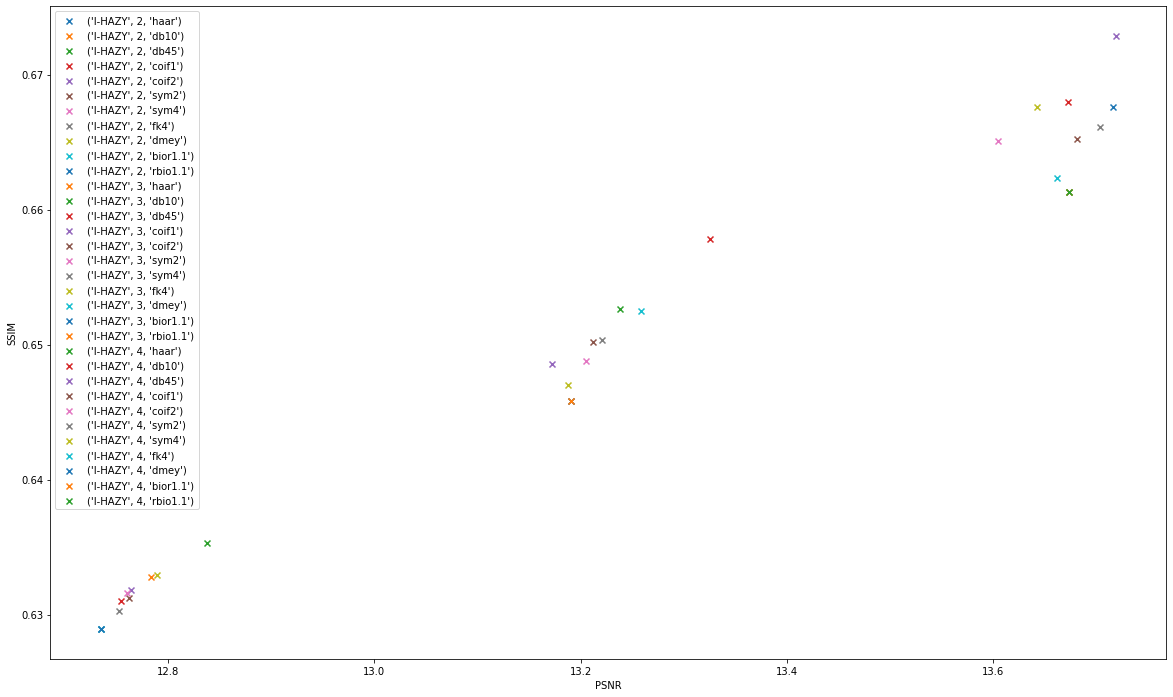

In [93]:
plt.figure(figsize=(20, 12))
legends = [k for k in OPC_psnr.keys() if k[0] == 'I-HAZY']
for index in legends:
    plt.scatter(np.mean(OPC_psnr[index]), np.mean(OPC_ssim[index]), marker='x')
plt.xlabel('PSNR')
plt.ylabel('SSIM')
plt.legend(legends)
plt.show() 

In [94]:
import pprint
keys = [k for k in OPC_psnr.keys() if k[0] == 'I-HAZY']
metriclist = [(np.mean(OPC_ssim[k]), np.mean(OPC_psnr[k]), k) for k in keys]
metriclist.sort()
metriclist.reverse()
print('    average SSIM     |    average PSNR    |     index')
pprint.pprint(metriclist)
print(f'best combination: {metriclist[0][2]}')

    average SSIM     |    average PSNR    |     index
[(0.6728554487228393, 13.718466458170779, ('I-HAZY', 4, 'db45')),
 (0.6680072029431661, 13.672612574060077, ('I-HAZY', 4, 'db10')),
 (0.6676159203052521, 13.715431841758734, ('I-HAZY', 4, 'dmey')),
 (0.667592030763626, 13.642309548472532, ('I-HAZY', 4, 'sym4')),
 (0.6661512235800425, 13.703613646054658, ('I-HAZY', 4, 'sym2')),
 (0.665214463075002, 13.680723427183382, ('I-HAZY', 4, 'coif1')),
 (0.665057568748792, 13.604161964971114, ('I-HAZY', 4, 'coif2')),
 (0.6623783111572266, 13.661227508923428, ('I-HAZY', 4, 'fk4')),
 (0.6613353351751964, 13.673518252057487, ('I-HAZY', 4, 'rbio1.1')),
 (0.6613353351751964, 13.673518252057487, ('I-HAZY', 4, 'haar')),
 (0.6613353351751964, 13.673518252057487, ('I-HAZY', 4, 'bior1.1')),
 (0.6578607976436615, 13.32571842670804, ('I-HAZY', 3, 'db45')),
 (0.6526461611191432, 13.237781416209113, ('I-HAZY', 3, 'db10')),
 (0.6525170087814331, 13.258517159590868, ('I-HAZY', 3, 'dmey')),
 (0.650359756747881

O-HAZY result

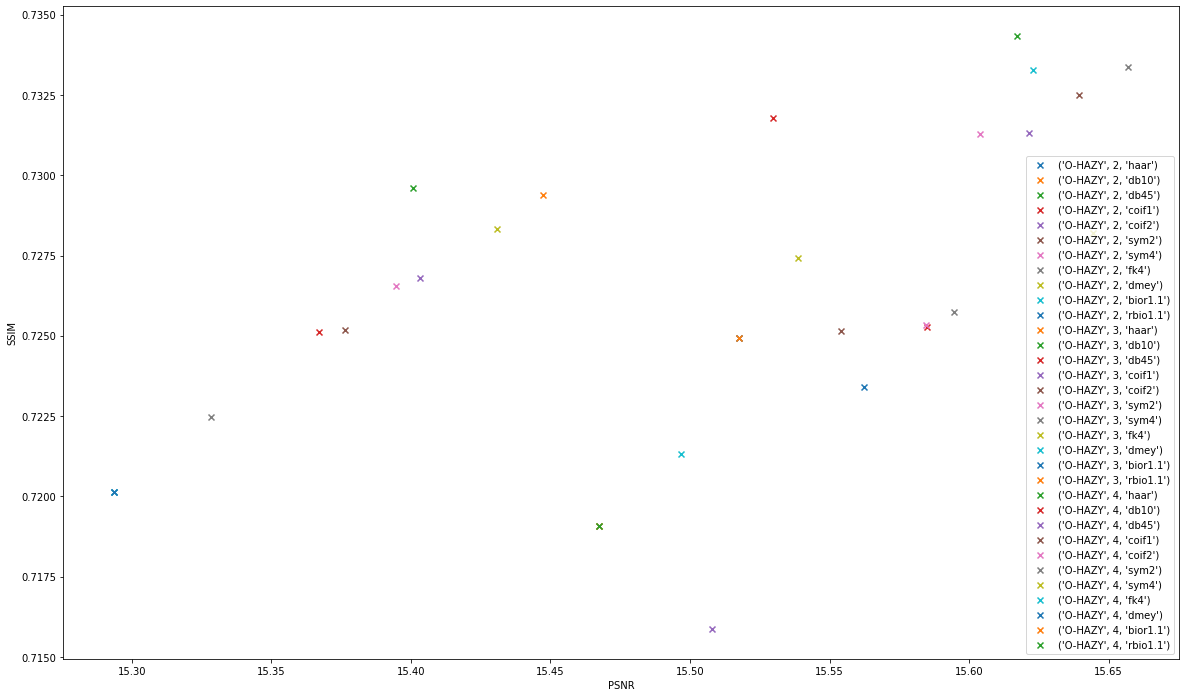

In [95]:
plt.figure(figsize=(20, 12))
legends = [k for k in OPC_psnr.keys() if k[0] == 'O-HAZY']
for index in legends:
    plt.scatter(np.mean(OPC_psnr[index]), np.mean(OPC_ssim[index]), marker='x')
plt.xlabel('PSNR')
plt.ylabel('SSIM')
plt.legend(legends)
plt.show() 

In [96]:
import pprint
keys = [k for k in OPC_psnr.keys() if k[0] == 'O-HAZY']
metriclist = [(np.mean(OPC_ssim[k]), np.mean(OPC_psnr[k]), k) for k in keys]
metriclist.sort()
metriclist.reverse()
print('    average SSIM     |    average PSNR    |     index')
pprint.pprint(metriclist)
print(f'best combination: {metriclist[0][2]}')

    average SSIM     |    average PSNR    |     index
[(0.7343323932753669, 15.617047544687814, ('O-HAZY', 3, 'db10')),
 (0.7333580944273207, 15.657136454232008, ('O-HAZY', 3, 'sym4')),
 (0.7332705961333381, 15.623035439673782, ('O-HAZY', 3, 'dmey')),
 (0.732502720091078, 15.63950070781343, ('O-HAZY', 3, 'coif2')),
 (0.7317860735787286, 15.529874037075832, ('O-HAZY', 3, 'db45')),
 (0.7313117702802022, 15.621474932055152, ('O-HAZY', 3, 'coif1')),
 (0.7312747637430826, 15.603927436124488, ('O-HAZY', 3, 'sym2')),
 (0.7296002176072862, 15.40063220343861, ('O-HAZY', 2, 'db45')),
 (0.7293963207138909, 15.447172982770372, ('O-HAZY', 2, 'db10')),
 (0.7283360441525777, 15.430668658290578, ('O-HAZY', 2, 'dmey')),
 (0.7281926234563192, 15.644324617674988, ('O-HAZY', 4, 'sym4')),
 (0.7274250149726867, 15.538550400686477, ('O-HAZY', 3, 'fk4')),
 (0.7268102036582099, 15.403118974472575, ('O-HAZY', 2, 'coif2')),
 (0.7265547487470839, 15.39470480622071, ('O-HAZY', 2, 'sym4')),
 (0.725747537612915, 15.

SOTS-indoor result

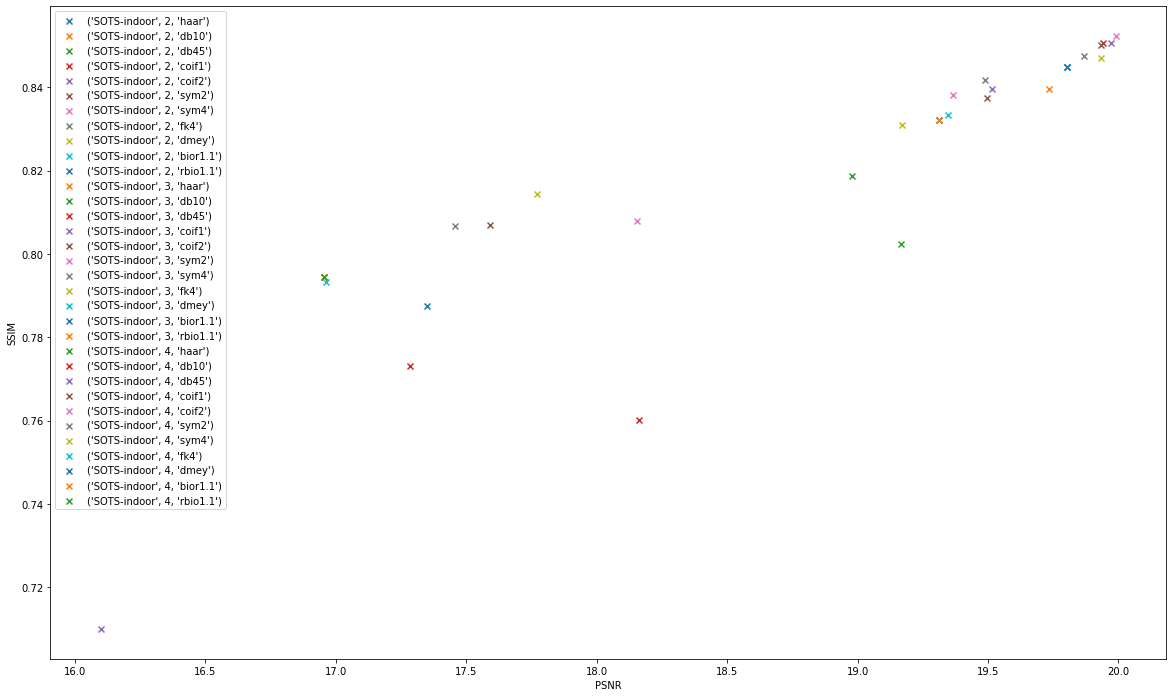

In [97]:
plt.figure(figsize=(20, 12))
legends = [k for k in OPC_psnr.keys() if k[0] == 'SOTS-indoor']
for index in legends:
    plt.scatter(np.mean(OPC_psnr[index]), np.mean(OPC_ssim[index]), marker='x')
plt.xlabel('PSNR')
plt.ylabel('SSIM')
plt.legend(legends)
plt.show() 

In [98]:
import pprint
keys = [k for k in OPC_psnr.keys() if k[0] == 'SOTS-indoor']
metriclist = [(np.mean(OPC_ssim[k]), np.mean(OPC_psnr[k]), k) for k in keys]
metriclist.sort()
metriclist.reverse()
print('    average SSIM     |    average PSNR    |     index')
pprint.pprint(metriclist)
print(f'best combination: {metriclist[0][2]}')

    average SSIM     |    average PSNR    |     index
[(0.852277501821518, 19.989740941877596, ('SOTS-indoor', 2, 'sym4')),
 (0.8507341587543488, 19.972341825370492, ('SOTS-indoor', 2, 'coif2')),
 (0.8505644655227661, 19.940418716808068, ('SOTS-indoor', 2, 'coif1')),
 (0.8502208423614502, 19.933054846458027, ('SOTS-indoor', 2, 'sym2')),
 (0.8474218928813935, 19.86984644270822, ('SOTS-indoor', 2, 'fk4')),
 (0.846979079246521, 19.934282784500155, ('SOTS-indoor', 2, 'dmey')),
 (0.844877177476883, 19.801847296878712, ('SOTS-indoor', 2, 'rbio1.1')),
 (0.844877177476883, 19.801847296878712, ('SOTS-indoor', 2, 'haar')),
 (0.844877177476883, 19.801847296878712, ('SOTS-indoor', 2, 'bior1.1')),
 (0.8417530930042267, 19.488191261802502, ('SOTS-indoor', 3, 'sym4')),
 (0.8396348416805267, 19.732770334403064, ('SOTS-indoor', 2, 'db10')),
 (0.8395433938503265, 19.516841962973057, ('SOTS-indoor', 3, 'coif1')),
 (0.838049373626709, 19.364941221912932, ('SOTS-indoor', 3, 'sym2')),
 (0.8373736441135406, 

SOTS-outdoor result

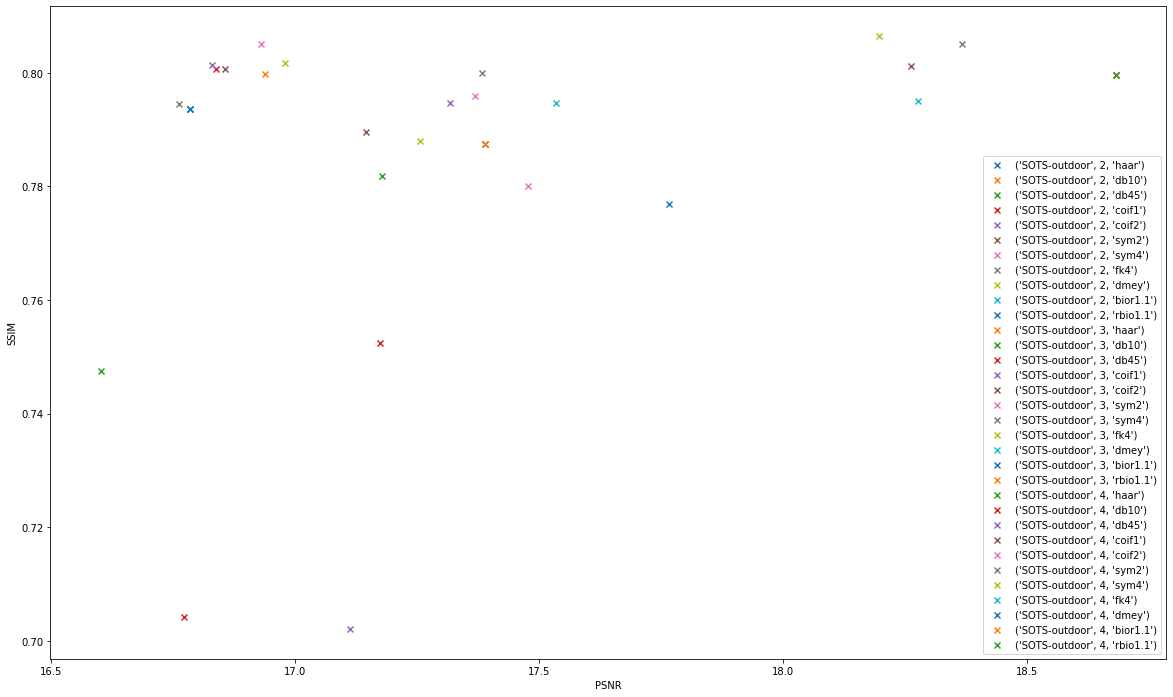

In [99]:
plt.figure(figsize=(20, 12))
legends = [k for k in OPC_psnr.keys() if k[0] == 'SOTS-outdoor']
for index in legends:
    plt.scatter(np.mean(OPC_psnr[index]), np.mean(OPC_ssim[index]), marker='x')
plt.xlabel('PSNR')
plt.ylabel('SSIM')
plt.legend(legends)
plt.show() 

In [100]:
import pprint
keys = [k for k in OPC_psnr.keys() if k[0] == 'SOTS-outdoor']
metriclist = [(np.mean(OPC_ssim[k]), np.mean(OPC_psnr[k]), k) for k in keys]
metriclist.sort()
metriclist.reverse()
print('    average SSIM     |    average PSNR    |     index')
pprint.pprint(metriclist)
print(f'best combination: {metriclist[0][2]}')

    average SSIM     |    average PSNR    |     index
[(0.806463973793557, 18.195517321228003, ('SOTS-outdoor', 4, 'sym4')),
 (0.8050436536228753, 18.366831639271314, ('SOTS-outdoor', 4, 'sym2')),
 (0.804993900099421, 16.930461305944213, ('SOTS-outdoor', 2, 'sym4')),
 (0.8016757916628829, 16.979626931934956, ('SOTS-outdoor', 2, 'dmey')),
 (0.8013484251450717, 16.830902853886716, ('SOTS-outdoor', 2, 'coif2')),
 (0.8012428941523156, 18.261187721926575, ('SOTS-outdoor', 4, 'coif1')),
 (0.8007336951852814, 16.83915547774917, ('SOTS-outdoor', 2, 'coif1')),
 (0.800627784152341, 16.8562139639834, ('SOTS-outdoor', 2, 'sym2')),
 (0.7999787797045902, 17.38414333954758, ('SOTS-outdoor', 3, 'sym4')),
 (0.7998354037602743, 16.938797922271394, ('SOTS-outdoor', 2, 'db10')),
 (0.7996058810532578, 18.68134835301922, ('SOTS-outdoor', 4, 'rbio1.1')),
 (0.7996058810532578, 18.68134835301922, ('SOTS-outdoor', 4, 'haar')),
 (0.7996058810532578, 18.68134835301922, ('SOTS-outdoor', 4, 'bior1.1')),
 (0.7959926

Average of four datasets：

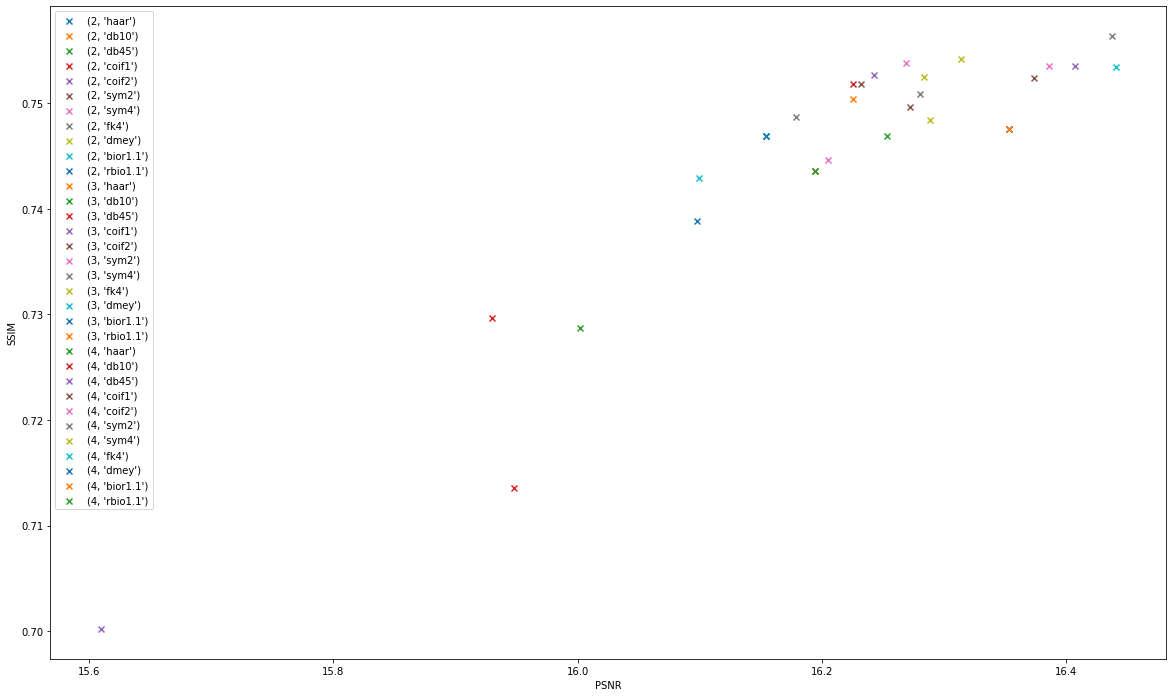

In [101]:
plt.figure(figsize=(20, 12))
OPC_psnr_mean = defaultdict(float)
OPC_ssim_mean = defaultdict(float)
legends = [k for k in OPC_psnr.keys() if k[0] == 'O-HAZY']
for k in OPC_psnr.keys():
    OPC_psnr_mean[k[1:]] += np.mean(OPC_psnr[k])
    OPC_ssim_mean[k[1:]] += np.mean(OPC_ssim[k])
for k in OPC_psnr_mean.keys():
    OPC_psnr_mean[k] /= 4
    OPC_ssim_mean[k] /= 4
legends = OPC_psnr_mean.keys()
for index in legends:
    plt.scatter(OPC_psnr_mean[index], OPC_ssim_mean[index], marker='x')
plt.xlabel('PSNR')
plt.ylabel('SSIM')
plt.legend(legends)
plt.show() 

In [102]:
import pprint
keys = OPC_psnr_mean.keys()
metriclist = [(OPC_ssim_mean[k], OPC_psnr_mean[k], k) for k in keys]
metriclist.sort()
metriclist.reverse()
print('    average SSIM     |    average PSNR    |     index')
pprint.pprint(metriclist)
print(f'best combination: {metriclist[0][2]}')

    average SSIM     |    average PSNR    |     index
[(0.7563624309710048, 16.43753176339538, (3, 'sym4')),
 (0.7541879266185489, 16.31351213892289, (4, 'sym4')),
 (0.7538584672342633, 16.268809979647813, (2, 'sym4')),
 (0.7535258897109245, 16.406835660531755, (3, 'coif1')),
 (0.7535258780868073, 16.386144974905452, (3, 'sym2')),
 (0.753484022860443, 16.440581261901954, (3, 'dmey')),
 (0.7526807413155309, 16.24264396153495, (2, 'coif2')),
 (0.7524823498532054, 16.283575060628177, (2, 'dmey')),
 (0.7524366189955373, 16.373353307157526, (3, 'coif2')),
 (0.7518513599260228, 16.22535485461305, (2, 'coif1')),
 (0.7518239668887967, 16.231911621612447, (2, 'sym2')),
 (0.7509243037242714, 16.280187082272295, (4, 'sym2')),
 (0.7504083636734221, 16.225608150663973, (2, 'db10')),
 (0.7496716267084526, 16.27202065412863, (4, 'coif1')),
 (0.7486710333266878, 16.178510647977184, (2, 'fk4')),
 (0.7483902833653174, 16.28869440791214, (3, 'fk4')),
 (0.7476030279720217, 16.35290406757451, (3, 'rbio1.1'